In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()

df = pd.concat((
    pd.read_csv('./data/October_missions_full.csv'),
    pd.read_csv('./data/November_1stW_missions_full.csv'),
), ignore_index=True)

df['mission'] = df['type'] + '_' + df['target'].astype(str)

df = df[['user', 'mission', 'createdAtT', 'type', 'target', 'completed', 'performance']]
df['createdAtT'] = pd.to_datetime(df['createdAtT'], unit='ms')
df['user'] = df['user'].astype('category').cat.codes
df['mission'] = df['mission'].astype('category')
df['type'] = df['type'].astype('category')

df.sort_values(by=['createdAtT', 'user'], inplace=True, ignore_index=True)
df

,user,mission,createdAtT,type,target,completed,performance
0,4845,quiz_2,2024-10-01 00:00:07.698,quiz,2,False,0.000000
1,4845,mobility_1,2024-10-01 00:00:07.698,mobility,1,True,1.000000
2,4845,activity_6,2024-10-01 00:00:07.698,activity,6,False,0.666667
3,2892,mobility_1,2024-10-01 00:00:17.857,mobility,1,False,0.000000
4,2892,episode_3,2024-10-01 00:00:17.857,episode,3,False,0.666667
...,...,...,...,...,...,...,...
110964,8089,action_2,2024-11-07 23:54:14.775,action,2,False,0.000000
110965,8089,mobility_4,2024-11-07 23:54:14.775,mobility,4,False,0.000000
110966,863,activity_9,2024-11-07 23:58:55.124,activity,9,False,0.000000
110967,863,quiz_1,2024-11-07 23:58:55.124,quiz,1,False,0.000000


/tmp/ipykernel_17244/1752879408.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['completed'] == False].groupby('mission').size().plot(kind='bar', figsize=(20, 10))


<Axes: xlabel='mission'>

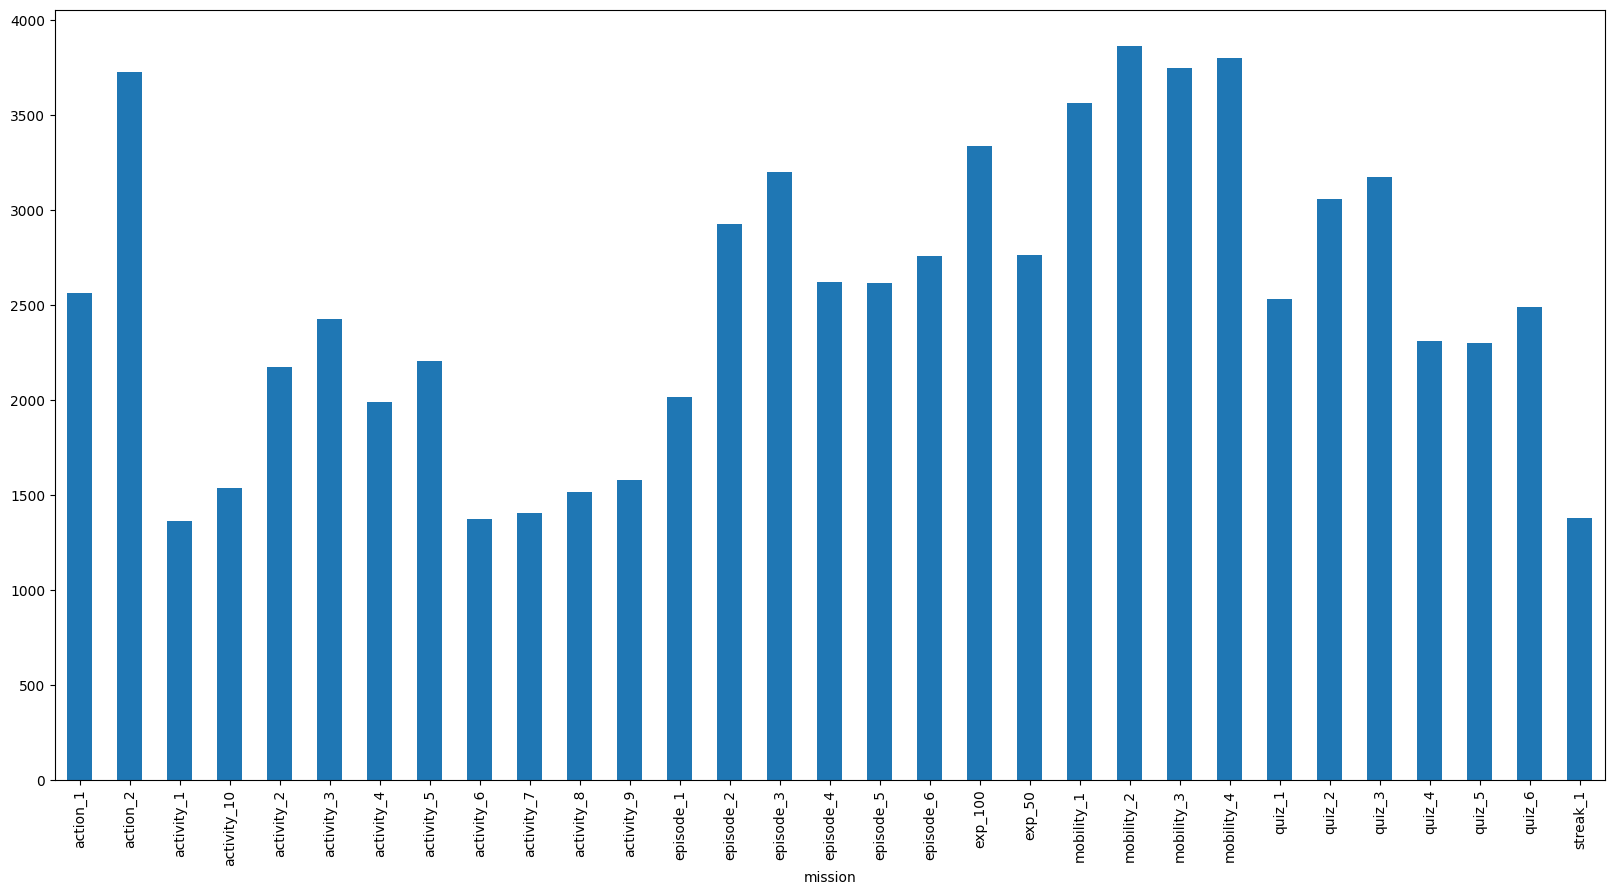

In [4]:
df[df['completed'] == False].groupby('mission').size().plot(kind='bar', figsize=(20, 10))

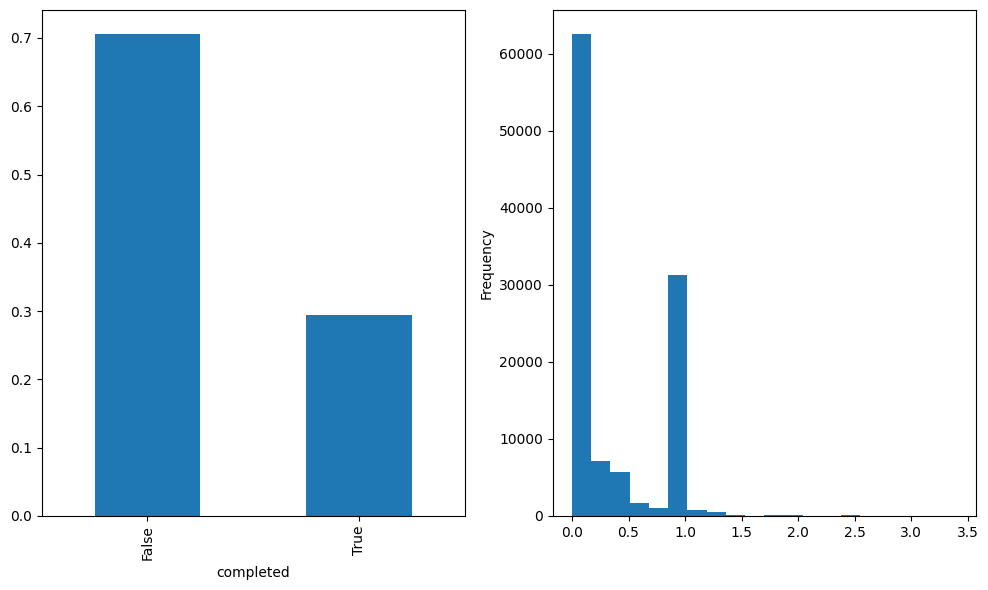

In [5]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
df['completed'].value_counts(normalize=True).plot(kind='bar')

plt.subplot(1, 2, 2)
df['performance'].plot.hist(bins=20)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

df.groupby('mission', observed=True).size().plot(kind='bar')

In [ ]:
plt.figure(figsize=(10, 6))

df.groupby('type', observed=True).size().plot(kind='bar')

In [ ]:
def sequences(x: pd.Series, df: pd.DataFrame, day_window=3):
    ts = x['createdAtT']
    ts_start = ts - pd.Timedelta(days=day_window)

    user_df: pd.DataFrame = df[(df['user'] == x['user']) & (df['createdAtT'] >= ts_start) & (df['createdAtT'] < ts)]
    user_df = user_df.sort_values(by='createdAtT', ascending=True)
    return pd.Series({
        'id': str(x['user']) + '_' + str(ts),
        'ts': ts,
        'mission': x['mission'],
        'ID': x['mission_id'],
        'history': user_df[['mission_id', 'ok']].astype(int).values
    })

def get_negatives(x: pd.Series):
    neg = missions - set(x)
    return [list(neg)] * len(x)

df['ok'] = df['performance'].apply(lambda x: 0.7 <= x <= 1.05)
df['mission_id'] = df['mission'].cat.codes
missions = set(df['mission_id'])

sequences_df: pd.DataFrame = df[df['ok']].progress_apply(sequences, axis=1, args=(df,))
sequences_df['negatives'] = sequences_df.groupby('id')['ID'].transform(get_negatives)

sequences_df

In [ ]:
sequences_df['ts'] = pd.to_datetime(sequences_df['ts'])
sequences_df = sequences_df[sequences_df['history'].apply(len) > 0]
train_df = sequences_df[sequences_df['ts'] < pd.Timestamp('2024-11-01')]
test_df = sequences_df[sequences_df['ts'] >= pd.Timestamp('2024-11-01')]

display(train_df)
display(test_df)

In [ ]:
train_df.to_pickle('./out/train.pkl')
test_df.to_pickle('./out/test.pkl')